In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/news-category-dataset/News_Category_Dataset_v3.json


In [2]:
import re
import random
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
!pip install bertopic==0.16.0 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.1/154.1 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 55.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 48.4 MB/s eta 0:00:00
  Attempting uninstall: cython
    Found existing installation: Cython 3.0.8
    Uninstalling Cython-3.0.8:
      Successfully uninstalled Cython-3.0.8


In [4]:
df = pd.read_json('/kaggle/input/news-category-dataset/News_Category_Dataset_v3.json', lines=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209527 entries, 0 to 209526
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   link               209527 non-null  object        
 1   headline           209527 non-null  object        
 2   category           209527 non-null  object        
 3   short_description  209527 non-null  object        
 4   authors            209527 non-null  object        
 5   date               209527 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(5)
memory usage: 9.6+ MB


In [6]:
dataset = df[['link', 'short_description', 'date', 'category']].copy()

In [7]:
dataset = dataset.sample(frac=1, random_state=101)
dataset.head()

,link,short_description,date,category
162293,https://www.huffingtonpost.com/entry/flight-at...,"Try as they might, airlines can't seem to live...",2013-06-17,TRAVEL
115371,https://www.huffingtonpost.com/entry/what-my-d...,It is unnatural for a childhood to be robbed o...,2014-11-14,PARENTS
157067,https://www.huffingtonpost.com/entry/huffpost-...,If you're a regular reader of the Huffington P...,2013-08-11,TECH
114986,https://www.huffingtonpost.com/entry/exes-figh...,,2014-11-19,ENTERTAINMENT
50313,https://www.huffingtonpost.com/entry/jill-stei...,The fundraiser surpassed its $2 million goal l...,2016-11-24,POLITICS


In [8]:
def clean_text(text):
    # Convert to lowercase
    text = text.lower().strip()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', ' url ', text, flags=re.MULTILINE)

    # Replace digits with the word 'digit'
    text = re.sub(r'\d+', ' digit ', text)

    # Set space before and after any punctuation
    text = re.sub(r'([.,!?()])', r' \1 ', text)

    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [9]:
dataset['short_description'] = dataset['short_description'].apply(clean_text)
dataset.head()

,link,short_description,date,category
162293,https://www.huffingtonpost.com/entry/flight-at...,"try as they might , airlines can't seem to liv...",2013-06-17,TRAVEL
115371,https://www.huffingtonpost.com/entry/what-my-d...,it is unnatural for a childhood to be robbed o...,2014-11-14,PARENTS
157067,https://www.huffingtonpost.com/entry/huffpost-...,if you're a regular reader of the huffington p...,2013-08-11,TECH
114986,https://www.huffingtonpost.com/entry/exes-figh...,,2014-11-19,ENTERTAINMENT
50313,https://www.huffingtonpost.com/entry/jill-stei...,the fundraiser surpassed its $ digit million g...,2016-11-24,POLITICS


In [10]:
dataset['description_len'] = dataset['short_description'].apply(len)
dataset.head()

,link,short_description,date,category,description_len
162293,https://www.huffingtonpost.com/entry/flight-at...,"try as they might , airlines can't seem to liv...",2013-06-17,TRAVEL,125
115371,https://www.huffingtonpost.com/entry/what-my-d...,it is unnatural for a childhood to be robbed o...,2014-11-14,PARENTS,206
157067,https://www.huffingtonpost.com/entry/huffpost-...,if you're a regular reader of the huffington p...,2013-08-11,TECH,326
114986,https://www.huffingtonpost.com/entry/exes-figh...,,2014-11-19,ENTERTAINMENT,0
50313,https://www.huffingtonpost.com/entry/jill-stei...,the fundraiser surpassed its $ digit million g...,2016-11-24,POLITICS,72


In [11]:
# value_counts = dataset['description_len'].value_counts()
    
# Sort the counts by the unique values (index)
# value_counts.sort_index()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='description_len', ylabel='Count'>

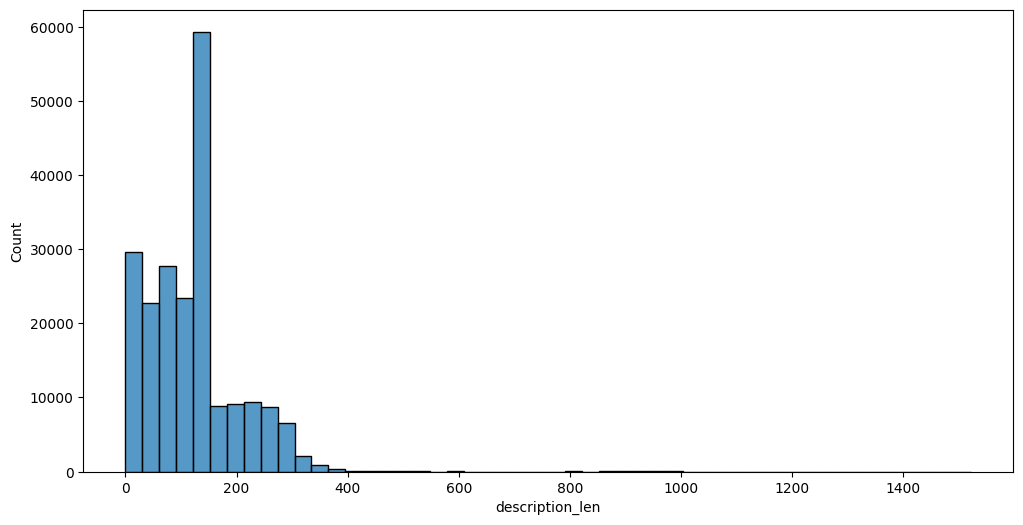

In [12]:
plt.figure(figsize=(12, 6))
sns.histplot(dataset['description_len'], bins=50)

In [13]:
print(dataset.shape)
dataset = dataset[dataset['description_len'] <= 400 ]
dataset = dataset[dataset['description_len'] > 0 ]

print(dataset.shape)

(209527, 5)
(189388, 5)


In [14]:
print(dataset.shape)
dataset.drop_duplicates(['short_description'], inplace=True)
print(dataset.shape)

(189388, 5)
(186480, 5)


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='description_len', ylabel='Count'>

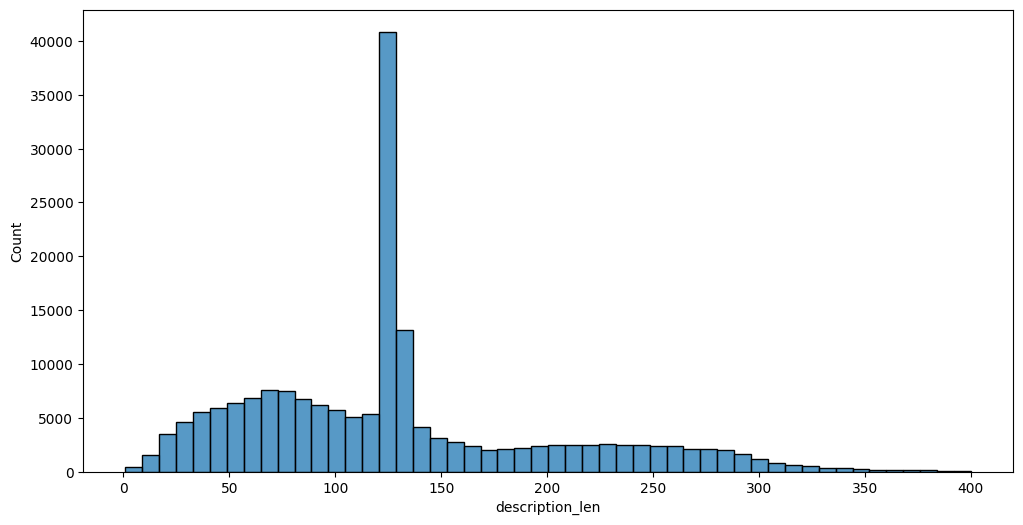

In [15]:
plt.figure(figsize=(12, 6))
sns.histplot(dataset['description_len'], bins=50)

In [16]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 186480 entries, 162293 to 176991
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   link               186480 non-null  object        
 1   short_description  186480 non-null  object        
 2   date               186480 non-null  datetime64[ns]
 3   category           186480 non-null  object        
 4   description_len    186480 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 8.5+ MB


## **Pre-calculate Embeddings**
BERTopic works by converting documents into numerical values, called embeddings. This process can be very costly, especially if we want to iterate over parameters. Instead, we can calculate those embeddings once and feed them to BERTopic to skip calculating embeddings each time.

In [17]:
from sentence_transformers import SentenceTransformer

# Pre-calculate embeddings
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = embedding_model.encode(dataset['short_description'].values, show_progress_bar=True)

/opt/conda/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
2024-06-14 15:24:28.293974: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-14 15:24:28.294113: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-14 15:24:28.446371: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/5828 [00:00<?, ?it/s]

## **dimensionality reduction**

In [18]:
from umap import UMAP

umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)

## **Controlling Number of Topics**

In [19]:
from hdbscan import HDBSCAN

hdbscan_model = HDBSCAN(min_cluster_size=150, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

## **Improving Default Representation**
preprocess the topic representations **after** documents are assigned to topics. This will not influence the clustering process in any way.

In [20]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer_model = CountVectorizer(stop_words="english", min_df=2, ngram_range=(1, 2))

## **Additional Representations**
In BERTopic, you can model many different topic representations simultanously to test them out and get different perspectives of topic descriptions. This is called multi-aspect topic modeling.

Here, we will use:

* KeyBERTInspired
  * A method that derives inspiration from how KeyBERT works
* PartOfSpeech
  * Using SpaCy's POS tagging to extract words
* MaximalMarginalRelevance
  * Diversify the topic words


In [21]:
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance, OpenAI, PartOfSpeech

# KeyBERT
keybert_model = KeyBERTInspired()

# Part-of-Speech
pos_model = PartOfSpeech("en_core_web_sm")

# MMR
mmr_model = MaximalMarginalRelevance(diversity=0.3)

# All representation models
representation_model = {
    "KeyBERT": keybert_model,
     "MMR": mmr_model,
    "POS": pos_model
}

## **Training**
* **Embedding Generation (embedding_model):** Converts raw text into dense, high-dimensional embeddings.
* **Dimensionality Reduction (umap_model):** Reduces the dimensionality of embeddings for efficient clustering.
* **Clustering (hdbscan_model):**** Groups similar embeddings to form clusters representing topics.
* **Sparse Representation (vectorizer_model):** Converts raw text into a sparse matrix highlighting important words.
* **Topic Representation (representation_model):** Refines topics by selecting representative keywords or phrases.

In [22]:
from bertopic import BERTopic

topic_model = BERTopic(

  # Pipeline models
  embedding_model=embedding_model,
  umap_model=umap_model,
  hdbscan_model=hdbscan_model,
  vectorizer_model=vectorizer_model,
  representation_model=representation_model,

  # Hyperparameters
  top_n_words=10,
  verbose=True
)

topics, probs = topic_model.fit_transform(dataset['short_description'].values, embeddings)

2024-06-14 15:51:19,931 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-06-14 15:56:43,157 - BERTopic - Dimensionality - Completed ✓
2024-06-14 15:56:43,169 - BERTopic - Cluster - Start clustering the reduced embeddings
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been us

In [23]:
print(
    dataset['short_description'].values[50],
    topics[50], probs[50]
)

topic_model.get_topic(17)

of the more than digit . digit million people worldwide who are diagnosed with multiple sclerosis , i am only one story . i am a wife , mother , daughter , daughter-in-law , sister , friend , and woman living with an incurable and unpredictable disease . and even though i am only one person , my story can add great value by educating othe -1 0.0


[('film', 0.052693445866332504),
 ('movie', 0.04610143147256744),
 ('films', 0.01935379408844318),
 ('movies', 0.01765837057149544),
 ('box office', 0.01723316691958669),
 ('director', 0.01493880367271597),
 ('weekend', 0.013983091834756121),
 ('digit million', 0.013881672254082185),
 ('actor', 0.013674858330032567),
 ('theaters', 0.0136395763307075)]

In [24]:
dataset['topic'] = topics
dataset['prob'] = probs

In [25]:
topic_model.visualize_topics()

In [26]:
topic_model.visualize_heatmap()

In [27]:
topics_per_class = topic_model.topics_per_class(
    dataset['short_description'].values,
    classes=dataset['category'].values,
)

42it [00:24,  1.73it/s]


In [28]:
topic_model.visualize_topics_per_class(topics_per_class, top_n_topics=20)

In [29]:
topics_over_time = topic_model.topics_over_time(
    dataset['short_description'].values,
    dataset['date'].values
)

2024-06-14 15:58:47,761 - BERTopic - WARNING: There are more than 100 unique timestamps (i.e., 3890) which significantly slows down the application. Consider setting `nr_bins` to a value lower than 100 to speed up calculation. 
3890it [38:13,  1.70it/s]


In [30]:
topic_model.visualize_topics_over_time(
    topics_over_time,
    topics=[10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
)

## **Inference**

In [31]:
story = "Sustainable energy refers to the production and use of energy in ways that are environmentally friendly, economically viable, and socially responsible. This topic encompasses a wide range of energy sources and technologies aimed at reducing our reliance on fossil fuels and minimizing the environmental impact of energy consumption."
_topic, _prob =  topic_model.transform([story])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-06-14 16:37:04,882 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
/opt/conda/lib/python3.10/site-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

2024-06-14 16:37:44,256 - BERTopic - Dimensionality - Completed ✓
2024-06-14 16:37:44,257 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2024-06-14 16:37:44,260 - BERTopic - Cluster - Completed ✓


## **save and load model**

In [32]:
model_id = "all-MiniLM-L6-v2"
topic_model.save("/content/safe_bertopic", serialization="safetensors",
                 save_ctfidf=True, save_embedding_model=model_id)

loaded_model = BERTopic.load("/content/safe_bertopic")

In [33]:
topic_model.save("/content/pickel_bert_topic_news.pkl", serialization="pickle")

loaded_model = BERTopic.load("/content/pickel_bert_topic_news.pkl")

2024-06-14 16:37:49,161 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.
